# Power Grid Network


### 1.1 Dataset


The following notebook studies Power Grid Network. This is *undirected, unweighted* network representing the topology of the Western States Power Grid of the United States. Each node is a power plant, transformer or consumer, and two nodes are connected if they are physically connected via a cable. This network fulfils the principles of the *small world network*.


Data was compiled by D. Watts and S. Strogatz and made available on the web:  [Dataset Link](https://pubmed.ncbi.nlm.nih.gov/9623998/).

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv

In [3]:
G = nx.Graph()

with open("static/powergrid_edgelist.txt", "r") as file:
    f1 = csv.reader(file, delimiter='\t')
    for row in f1:
        node1, node2 = map(int, row)
        G.add_edge(node1, node2)

total_nodes = G.number_of_nodes()
total_edges = G.number_of_edges()

print(f'Number of nodes: {total_nodes}')
print(f'Number of edges: {total_edges}')

Number of nodes: 4941
Number of edges: 6594


The dataset contains **192244** nodes and **609066** edges.

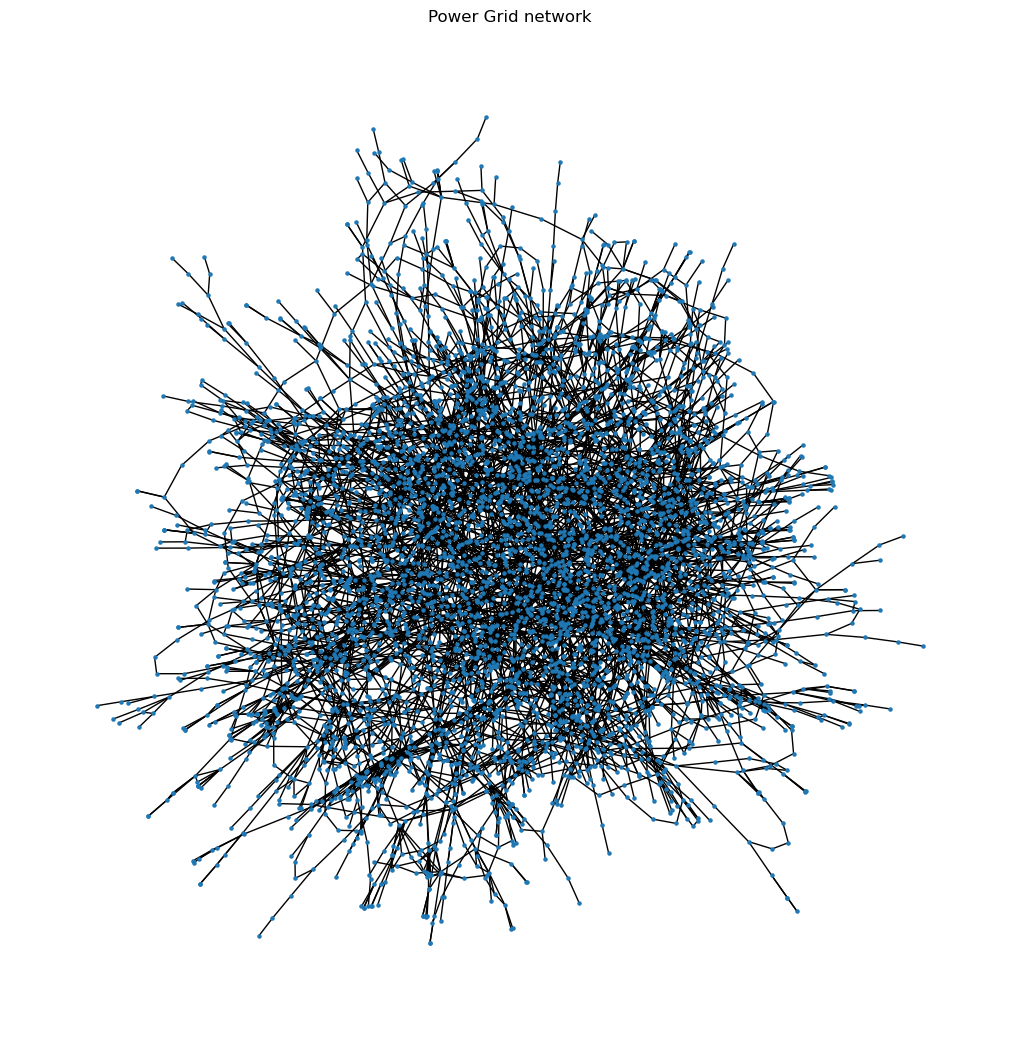

In [5]:
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=5)
plt.title("Power Grid network")
plt.show()

### 1.2 Network characterization

#### 1.2.1 Giant Component

In the context of a power grid network, the giant component represents a highly interconnected subset of electric infrastructure within the overall network topology.

In [8]:
giant_component = max(nx.connected_components(G), key=len)

G_giant = G.subgraph(giant_component)


giant_component_nodes = G_giant.number_of_nodes()
giant_component_edges = G_giant.number_of_edges()


giant_nodes_percentage = 100 * giant_component_nodes / total_nodes
giant_edges_percentage = 100 * giant_component_edges / total_edges

print(f'Number of nodes in the giant component: {giant_component_nodes} ({giant_nodes_percentage:.2f}% of all nodes)')
print(f'Number of edges in the giant component: {giant_component_edges} ({giant_edges_percentage:.2f}% of all edges)')

Number of nodes in the giant component: 4941 (100.00% of all nodes)
Number of edges in the giant component: 6594 (100.00% of all edges)


As we can see above every node and as a consequence every edge of the network belongs to the giant component. In this context, the conclusion is that the power grid network to ensure robustness and resilience against node failures or disruptions doesn't have any subgraphs and is centralized. 

In [11]:
# Average degree
average_degree = 2 * total_edges / total_nodes

# Average path length
average_path_length = nx.average_shortest_path_length(G)

# Diameter 
diameter = nx.approximation.diameter(G)

# Clustering Coefficient
clustering_coefficient = nx.average_clustering(G)




print(f'Average Degree: {average_degree:.2f}')
print(f'Average Path Length: {average_path_length:.2f}')
print(f'Diameter: {diameter}')
print(f'Clustering Coefficient: {clustering_coefficient:.2f}')

Average Degree: 2.67
Average Path Length: 18.99
Diameter: 46
Clustering Coefficient: 0.08


 **Average node degree of 2.67** suggest a moderate level of connectivity among electic infrastructure. It suggests a sufficient level of interconnection for the network's operations, as electrical failures don't happen that often, and 1 or 2 alternatives is enough in this context. This also reflects a less complex network structure compared to other types of networks. 

**Average Path Length of 18.99** and **diameter of 46** demonstrates that the Power Grid network has relatively longer distances between nodes. These values imply that data transmission or power distribution may experience higher latency or require more intermediate steps. This is perfectly reasonable, since entire West Coast is more than 2000 km long and connecting one northern point to one southern requires multiple intermediary nodes. This reflects the extensive geographical coverage of the power grid infrastructure.

**Clustering Coefficient of 0.08** exhibits a low level of clustering. This indicates that neighboring nodes in the network are not highly likely to be connected to each other. This is also an indicative of structural similarity of power grid network to a planar graph, where nodes are connected in such a way that graphs can be drawn on a plane without any edges crossing each other.

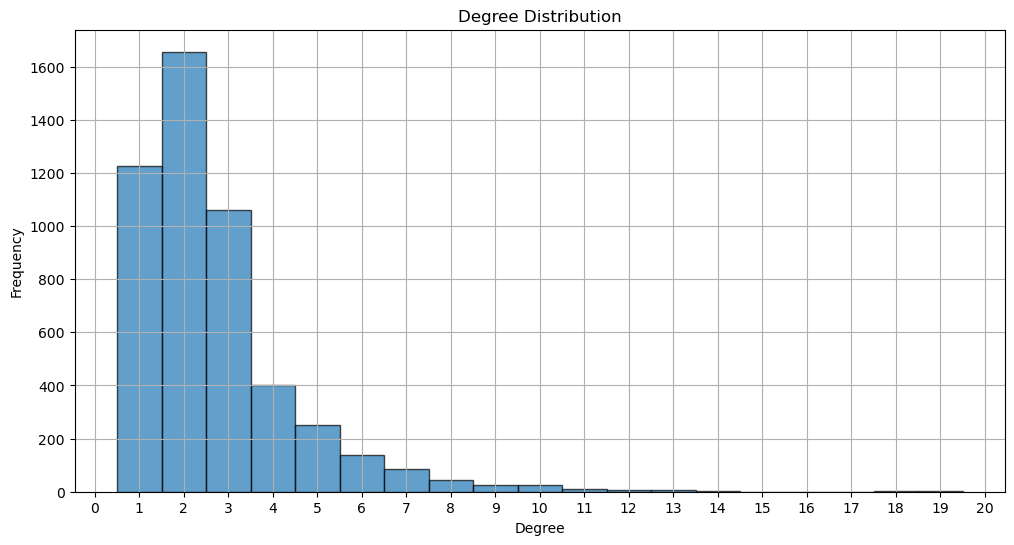

In [91]:
# Assuming G is your network
degree_sequence = [d for n, d in G.degree()]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(degree_sequence, bins=range(1, 21, 1), alpha=0.7, edgecolor='black', align='left')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.xticks(range(0, 21, 1))
plt.grid(True)
plt.show()

In [92]:
specified_values = [x for x in range(20)]

hist, _ = np.histogram(degree_sequence, bins=range(0, 21, 1))

# Extract counts for the specified values
counts_for_specified_values = {value: hist[value] for value in specified_values}

del(counts_for_specified_values[0])

print("Counts for Specified Values:")
for value, count in counts_for_specified_values.items():
    print(f"Value {value}: Count {count}")

Counts for Specified Values:
Value 1: Count 1226
Value 2: Count 1656
Value 3: Count 1060
Value 4: Count 401
Value 5: Count 252
Value 6: Count 137
Value 7: Count 84
Value 8: Count 46
Value 9: Count 27
Value 10: Count 26
Value 11: Count 11
Value 12: Count 5
Value 13: Count 5
Value 14: Count 3
Value 15: Count 0
Value 16: Count 0
Value 17: Count 0
Value 18: Count 1
Value 19: Count 1


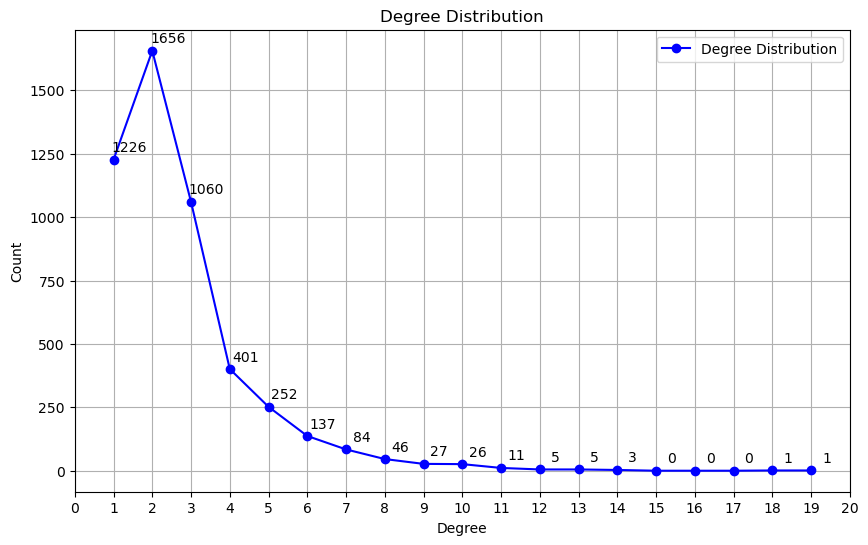

In [93]:
degrees = list(counts_for_specified_values.keys())
degree_counts = list(counts_for_specified_values.values())

fig = plt.figure(figsize=(10, 6))
plt.plot(degrees, degree_counts, 'bo-', label='Degree Distribution')
plt.xlabel('Degree')
plt.xticks(range(0, 21, 1))
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.grid(True)
plt.legend()

for degree, count in zip(degrees, degree_counts):
    plt.text(degree + 0.4, count + 20, str(count), ha='center', va='bottom')

# Save the plot as a variable
degree_distribution_plot = fig

plt.show()


In [94]:
from scipy.optimize import curve_fit

def func(x, a, k):
    return a * np.power(x, -k)

def get_power_law_curve(degrees, degree_counts):
    popt, pcov = curve_fit(func, degrees, degree_counts)

    # Extract optimized parameters
    a_opt, k_opt = popt

    # Generate the fitted curve
    fitted_curve = func(degrees, a_opt, k_opt)  

    return [fitted_curve, a_opt, k_opt]

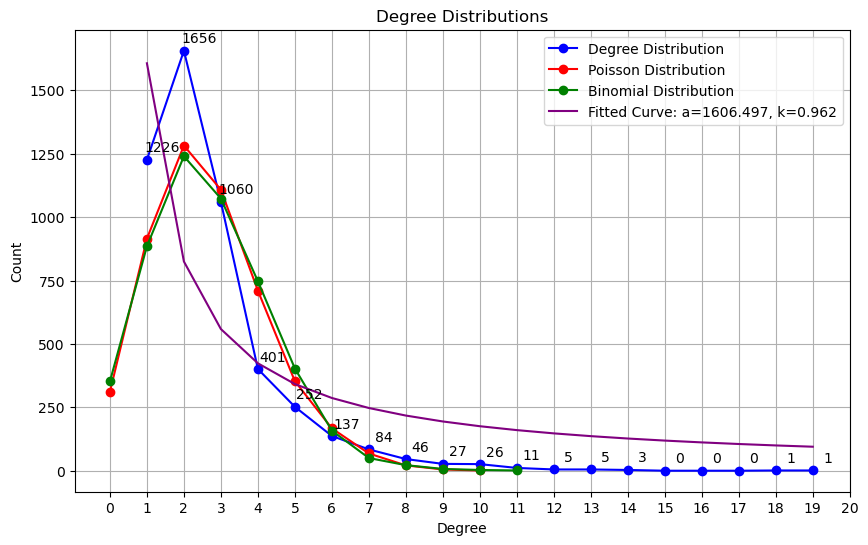

In [95]:
power_law_curve, a_opt, k_opt = get_power_law_curve(degrees, degree_counts)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Degree Distribution
ax.plot(degrees, degree_counts, 'bo-', label='Degree Distribution')

# Add count annotations
for degree, count in zip(degrees, degree_counts):
    ax.text(degree + 0.4, count + 20, str(count), ha='center', va='bottom')

# Generate Poisson and Binomial distributions
poisson = np.random.poisson(average_degree, total_nodes)
poisson_degree_sequence = sorted(poisson, reverse=True)
poisson_degreeCount = np.array(np.unique(poisson_degree_sequence, return_counts=True)).T
poisson_degreeCount = poisson_degreeCount[poisson_degreeCount[:, 0].argsort()]
poisson_degree, poisson_count = poisson_degreeCount.T

binomial = np.random.binomial(total_nodes, average_degree / total_nodes, total_nodes)
binomial_degree_sequence = sorted(binomial, reverse=True)
binomial_degreeCount = np.array(np.unique(binomial_degree_sequence, return_counts=True)).T
binomial_degreeCount = binomial_degreeCount[binomial_degreeCount[:, 0].argsort()]
binomial_degree, binomial_count = binomial_degreeCount.T

# Plot Poisson Distribution
ax.plot(poisson_degree, poisson_count, 'ro-', label='Poisson Distribution')

# Plot Binomial Distribution
ax.plot(binomial_degree, binomial_count, 'go-', label='Binomial Distribution')

# Plot Power Law Distribution
plt.plot(degrees, power_law_curve, color='purple', label='Fitted Curve: a=%5.3f, k=%5.3f' % (a_opt, k_opt))

# Set labels and title
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
plt.xticks(range(0, 21, 1))
ax.set_title('Degree Distributions')
ax.grid(True)
ax.legend()

plt.show()


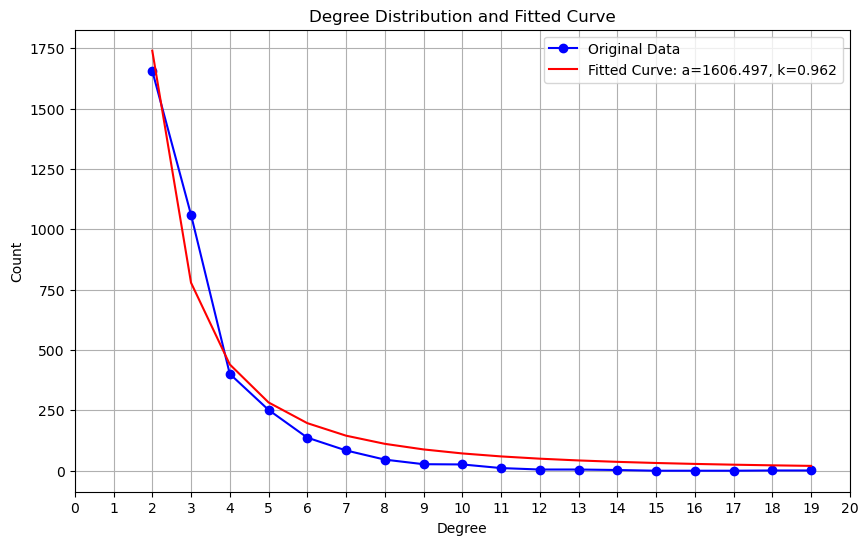

Optimized Parameters:
a = 1606.4973100186635
k = 0.9616663071151159


In [96]:
counts_copy = counts_for_specified_values
try:
    del(counts_copy[1])
except:
    print("Already deleted")

degrees_copy = list(counts_copy.keys())
degree_counts_copy = list(counts_copy.values())

power_law_curve_adjusted, copy_a_opt, copy_k_opt= get_power_law_curve(degrees_copy, degree_counts_copy)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(degrees_copy, degree_counts_copy, 'bo-', label='Original Data')
plt.plot(degrees_copy, power_law_curve_adjusted, 'r-', label='Fitted Curve: a=%5.3f, k=%5.3f' % (a_opt, k_opt))
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution and Fitted Curve')
plt.legend()
plt.xticks(range(0, 21, 1))
plt.grid(True)
plt.show()

print("Optimized Parameters:")
print("a =", a_opt)
print("k =", k_opt)

Element already deleted


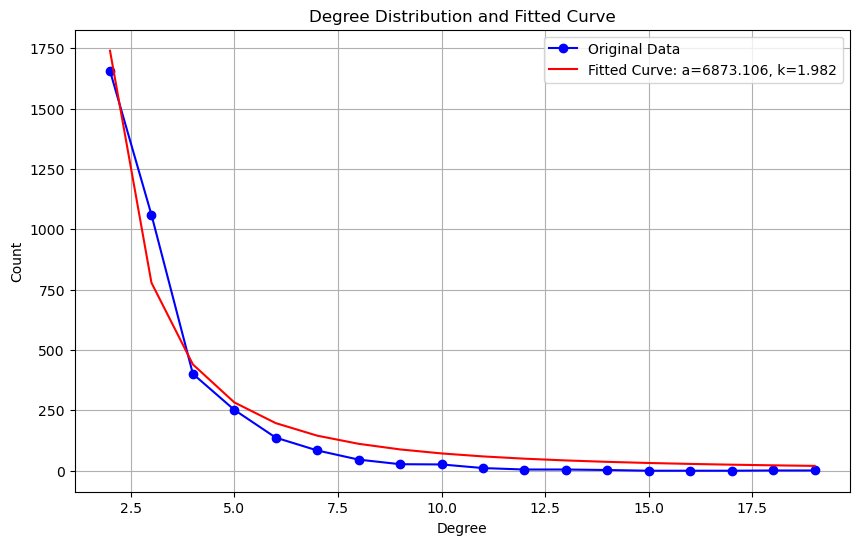

Optimized Parameters:
a = 6873.10577675627
k = 1.982326108906903


In [97]:
counts_for_specified_values_copy = counts_for_specified_values

try:
    del(counts_for_specified_values_copy[1])
except:
    print("Element already deleted")

degrees = list(counts_for_specified_values_copy.keys())
degree_counts = list(counts_for_specified_values_copy.values())
# Perform curve fitting
popt, pcov = curve_fit(func, degrees, degree_counts)

# Extract optimized parameters
a_opt, k_opt = popt

# Generate the fitted curve
fitted_curve = func(degrees, a_opt, k_opt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(degrees, degree_counts, 'bo-', label='Original Data')
plt.plot(degrees, fitted_curve, 'r-', label='Fitted Curve: a=%5.3f, k=%5.3f' % (a_opt, k_opt))
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution and Fitted Curve')
plt.legend()
plt.grid(True)
plt.show()

print("Optimized Parameters:")
print("a =", a_opt)
print("k =", k_opt)

In [99]:
# # Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Calculate PageRank
pagerank = nx.pagerank(G)

# Dataframe will all the values
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree': list(degree_centrality.values()),
    'Closeness': list(closeness_centrality.values()),
    'Betweenness': list(betweenness_centrality.values()),
    'PageRank': list(pagerank.values())
})

centrality_df

,Node,Degree,Closeness,Betweenness,PageRank
0,0,0.000607,0.066088,0.002515,0.000211
1,386,0.001215,0.063652,0.001307,0.000445
2,395,0.001012,0.070713,0.037108,0.000318
3,451,0.000607,0.062035,0.001180,0.000232
4,1,0.000810,0.045759,0.005204,0.000296
...,...,...,...,...,...
4936,4932,0.000405,0.047177,0.002023,0.000185
4937,4935,0.000405,0.045055,0.001618,0.000201
4938,4933,0.000405,0.047177,0.000357,0.000180
4939,4939,0.000405,0.045058,0.000026,0.000184


In [ ]:
centrality_df.set_index('Node', inplace=True)

In [106]:
centrality_df['Geometric_Average'] = np.power(centrality_df['Degree'] * centrality_df['Closeness'] * centrality_df['Betweenness'] * centrality_df['PageRank'], 1/4)

top_10_nodes = centrality_df.sort_values(by='Geometric_Average', ascending=False).head(10)

print(0.003644 * total_nodes)
top_10_nodes

18.005004


,Degree,Closeness,Betweenness,PageRank,Geometric_Average
Node,,,,,
4458,0.003644,0.067545,0.045791,0.001215,0.010818
4164,0.001417,0.076838,0.288416,0.000411,0.010657
2543,0.001215,0.078026,0.281698,0.000360,0.009903
1243,0.001215,0.079327,0.279695,0.000355,0.009891
2606,0.001417,0.079626,0.203116,0.000402,0.009798
2528,0.001215,0.078773,0.267304,0.000351,0.009736
69,0.001417,0.071668,0.184123,0.000464,0.009652
1166,0.002024,0.067786,0.106777,0.000585,0.009620
2235,0.001619,0.073570,0.153654,0.000460,0.009577
